# Importer le modèle Word2Vec

In [2]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gensim
from gensim.models import word2vec

random.seed(1)
np.random.seed(1)

In [3]:
os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

In [5]:
nom_dossier = 'ens'
# dim = 50
dim = 300
epoch = 100
window = 4
learning_rate = 0.02
    
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

In [6]:
matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

## On importe les données de train et on calcule le "sentence-embedding"

In [7]:
# Si on veut récup les fichiers
with open("data/sentimental_analysis/corpus_test.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train.file", "rb") as f:
    corpus_train = pickle.load(f)

In [22]:
def calcul_sentence_embedding(phrase):
    if len(phrase)>0:
        sum1 = sum(matrice[mot] for mot in phrase if mot in model1.wv.index2word)
        sum2 = sum(matrice["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
        return (sum1+sum2)/len(phrase)
    else:
        return matrice["lowfrequencyword"]

In [9]:
phrases = [[tweet.split(),score] for (score, tweet) in corpus_train]

In [10]:
phrases_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases]

In [11]:
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]

In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
reg_log = lr.fit(X_train,Y_train)

In [13]:
Y_train_pred = reg_log.predict(X_train)

from sklearn import metrics
# Matrice confusion
cm = metrics.confusion_matrix(Y_train,Y_train_pred)
print(cm)
# Accuracy
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 

[[18048  6952]
 [ 7229 17771]]
0.71638


In [14]:
phrases_test = [[tweet.split(),score] for (score, tweet) in corpus_test]
phrases_test_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log.predict(X_test)

In [143]:
# Matrice confusion
cm_test = metrics.confusion_matrix(Y_test,Y_test_pred)
print(cm_test)
# Accuracy
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

[[1438  546]
 [ 633 1365]]
0.703917629331994


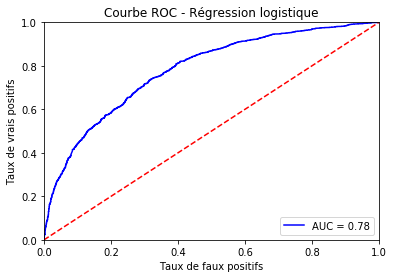

In [17]:
# Essai courbe ROC
import sklearn.metrics as metrics
probs = reg_log.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Courbe ROC - Régression logistique')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.show()

## Pourquoi ce score ?

In [49]:
phrases = [tweet.split() for (score, tweet) in corpus_train]
mots = [item for sublist in phrases for item in sublist]
vocabulaire = list(dict.fromkeys(mots))
n = 0
absents = []
for word in vocabulaire:
    if word not in model1.wv.index2word:
        n+=1
        absents.append(word)
print(n)
print(len(vocabulaire))

21204
39650


In [50]:
n/len(vocabulaire)

0.5347793190416141

## Stopwords

In [35]:
import nltk
from nltk.corpus import stopwords
stop_words =  set(stopwords.words('french'))

In [36]:
def suppr_stop(phrase):
    return [mot for mot in phrase if mot not in stop_words]
    
phrases_stop = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_train]

In [37]:
print(phrases[0])
print(phrases_stop[0])

[['est', 'très', 'heureux', 'que', 'aujourdhui', 'marque', '6', 'merveilleux', 'mois', 'avec', 'stephanie'], 1]
[['très', 'heureux', 'aujourdhui', 'marque', '6', 'merveilleux', 'mois', 'stephanie'], 1]


In [38]:
phrases_emb_stop = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_stop]
Y_train_stop = [score for (score, embedding) in phrases_emb_stop]
X_train_stop = [embedding for (score, embedding) in phrases_emb_stop]

In [39]:
lr_stop = LogisticRegression()
reg_log_st = lr_stop.fit(X_train_stop,Y_train_stop)

In [40]:
Y_train_pred_stop = reg_log_st.predict(X_train_stop)

# Matrice confusion
cm_stop = metrics.confusion_matrix(Y_train_stop,Y_train_pred_stop)
print(cm_stop)
# Accuracy
acc_stop = metrics.accuracy_score(Y_train_stop,Y_train_pred_stop)
print(acc_stop) 


phrases_test_stop = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_test]
phrases_test_emb_stop = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test_stop]
Y_test_stop = [score for (score, embedding) in phrases_test_emb_stop]
X_test_stop = [embedding for (score, embedding) in phrases_test_emb_stop]
Y_test_pred_stop = reg_log_st.predict(X_test_stop)

# Matrice confusion
cm_test_stop = metrics.confusion_matrix(Y_test_stop,Y_test_pred_stop)
print(cm_test_stop)
# Accuracy
acc_test_stop = metrics.accuracy_score(Y_test_stop,Y_test_pred_stop)
print(acc_test_stop) 

[[17455  7545]
 [ 7415 17585]]
0.7008
[[1388  596]
 [ 617 1381]]
0.6953792064289301


In [150]:
# On sauve les modèles
with open("data/sentimental_analysis/reg_log_300.file", "wb") as f:
    pickle.dump(reg_log, f, pickle.HIGHEST_PROTOCOL)
with open("data/sentimental_analysis/reg_log_st_300.file", "wb") as f:
    pickle.dump(reg_log_st, f, pickle.HIGHEST_PROTOCOL)

# Modèle : combiner régression logistique + poids des mots

In [4]:
with open("data/sentimental_analysis/reg_log_300.file", "rb") as f:
    reg_log_300 = pickle.load(f)
with open("data/sentimental_analysis/reg_log_st_300.file", "rb") as f:
    reg_log_st_300 = pickle.load(f)
with open("data/sentimental_analysis/reg_log_50.file", "rb") as f:
    reg_log_50 = pickle.load(f)
with open("data/sentimental_analysis/reg_log_st_50.file", "rb") as f:
    reg_log_st_50 = pickle.load(f)

In [18]:
phrases = [tweet.split() for (score, tweet) in corpus_train]
mots = [item for sublist in phrases for item in sublist]
vocabulaire = list(dict.fromkeys(mots))
matrice_sentiments = {mot:(0,0) for mot in vocabulaire}

def sentiment_plus(mot):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus+1,moins)
    
def sentiment_moins(mot):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus,moins+1)
    
for (score, tweet) in corpus_train:
    for mot in tweet.split():
        if score == 1:
            sentiment_plus(mot)
        else:
            sentiment_moins(mot)
            
matrice_sentiments_val = {mot:(matrice_sentiments[mot][0]-matrice_sentiments[mot][1])/((matrice_sentiments[mot][0]+matrice_sentiments[mot][1]))
                          for mot in vocabulaire}

In [31]:
def calcul_sentence_embedding_pond(phrase):
    if len(phrase)>0:
        sum1 = sum(matrice[mot]*matrice_sentiments_val[mot] for mot in phrase if mot in model1.wv.index2word and mot in vocabulaire)
        sum2 = sum(matrice["lowfrequencyword"]*0 for mot in phrase if mot not in model1.wv.index2word)
        return (sum1+sum2)/len(phrase)
    else:
        return matrice["lowfrequencyword"]

print(calcul_sentence_embedding(["le","test"])[0])
print(calcul_sentence_embedding_pond(["le","test"])[0])

-0.073868036
-0.002513292


In [27]:
phrases = [[tweet.split(),score] for (score, tweet) in corpus_train]
phrases_emb = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases]

In [28]:
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]
lr = LogisticRegression()
reg_log = lr.fit(X_train,Y_train)

Y_train_pred = reg_log.predict(X_train)

from sklearn import metrics
# Matrice confusion
cm = metrics.confusion_matrix(Y_train,Y_train_pred)
print(cm)
# Accuracy
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 

C:\Users\torna\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[20243  4757]
 [ 4535 20465]]
0.81416


In [32]:
phrases_test = [[tweet.split(),score] for (score, tweet) in corpus_test]
phrases_test_emb = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log.predict(X_test)
# Matrice confusion
cm_test = metrics.confusion_matrix(Y_test,Y_test_pred)
print(cm_test)
# Accuracy
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

[[1427  557]
 [ 597 1401]]
0.7101958814665997


In [34]:
import nltk
from nltk.corpus import stopwords
stop_words =  set(stopwords.words('french'))

def suppr_stop(phrase):
    return [mot for mot in phrase if mot not in stop_words]
    
phrases_stop = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_train]

phrases_emb_stop = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases_stop]
Y_train_stop = [score for (score, embedding) in phrases_emb_stop]
X_train_stop = [embedding for (score, embedding) in phrases_emb_stop]

lr_stop = LogisticRegression()
reg_log_st = lr_stop.fit(X_train_stop,Y_train_stop)

Y_train_pred_stop = reg_log_st.predict(X_train_stop)

# Matrice confusion
cm_stop = metrics.confusion_matrix(Y_train_stop,Y_train_pred_stop)
print(cm_stop)
# Accuracy
acc_stop = metrics.accuracy_score(Y_train_stop,Y_train_pred_stop)
print(acc_stop) 


phrases_test_stop = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_test]
phrases_test_emb_stop = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases_test_stop]
Y_test_stop = [score for (score, embedding) in phrases_test_emb_stop]
X_test_stop = [embedding for (score, embedding) in phrases_test_emb_stop]
Y_test_pred_stop = reg_log_st.predict(X_test_stop)

# Matrice confusion
cm_test_stop = metrics.confusion_matrix(Y_test_stop,Y_test_pred_stop)
print(cm_test_stop)
# Accuracy
acc_test_stop = metrics.accuracy_score(Y_test_stop,Y_test_pred_stop)
print(acc_test_stop) 

[[20110  4890]
 [ 4558 20442]]
0.81104
[[1407  577]
 [ 607 1391]]
0.7026619789050729
